# Import packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from IPython.display import display


%matplotlib inline
plt.style.use('bmh')

SEED = 42  # Random seed to be used throughout the notebook

# Read data

In [2]:
# Data from Kaggle competition
comp_data_df_train = pd.read_csv("data/competition-data/train.csv")
df_test = pd.read_csv("data/competition-data/test.csv")

# Original data
orig_data_df = pd.read_csv("data/original-data/smoking.csv")

In [3]:
df_test.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,...,186,49,115,14.2,1,0.9,19,25,32,0
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,...,158,35,104,13.0,1,1.1,20,12,24,0
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,...,173,39,88,15.4,1,1.4,38,60,36,0
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,...,47,75,128,14.5,1,0.6,25,18,10,1
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,...,100,39,123,16.5,1,1.0,30,39,27,1


In [4]:
orig_data_df.head()

,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,...,12.9,1.0,0.7,18.0,19.0,27.0,Y,0,Y,0
1,1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,...,12.7,1.0,0.6,22.0,19.0,18.0,Y,0,Y,0
2,2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,...,15.8,1.0,1.0,21.0,16.0,22.0,Y,0,N,1
3,3,M,40,165,70,88.0,1.5,1.5,1.0,1.0,...,14.7,1.0,1.0,19.0,26.0,18.0,Y,0,Y,0
4,4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,...,12.5,1.0,0.6,16.0,14.0,22.0,Y,0,N,0


In [5]:
comp_data_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

In [6]:
orig_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   55692 non-null  int64  
 1   gender               55692 non-null  object 
 2   age                  55692 non-null  int64  
 3   height(cm)           55692 non-null  int64  
 4   weight(kg)           55692 non-null  int64  
 5   waist(cm)            55692 non-null  float64
 6   eyesight(left)       55692 non-null  float64
 7   eyesight(right)      55692 non-null  float64
 8   hearing(left)        55692 non-null  float64
 9   hearing(right)       55692 non-null  float64
 10  systolic             55692 non-null  float64
 11  relaxation           55692 non-null  float64
 12  fasting blood sugar  55692 non-null  float64
 13  Cholesterol          55692 non-null  float64
 14  triglyceride         55692 non-null  float64
 15  HDL                  55692 non-null 

# Combine datasets

In [7]:
# drop columns
comp_data_df_train = comp_data_df_train.drop(columns=['id'])
df_test = df_test.drop(columns=['id'])
orig_data_df = orig_data_df.drop(columns=['ID', 'gender', 'oral', 'tartar'])

In [8]:
orig_data_df.shape

(55692, 23)

In [9]:
print("competition train shape:", comp_data_df_train.shape)
print("original train shape:", orig_data_df.shape)

competition train shape: (159256, 23)
original train shape: (55692, 23)


In [10]:
# combine datasets
df_train = pd.concat([comp_data_df_train, orig_data_df])
df_train.shape

(214948, 23)

# Clean data

## Remove duplicate rows

In [11]:
df_train = df_train.drop_duplicates()
df_train.shape

(203808, 23)

## Check for missing values

We can see that there are no missing values in the train or test dataset

In [12]:
df_train.isna().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

In [13]:
df_test.isna().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
dtype: int64

## Rename columns

In [14]:
new_col_names = {
    "systolic": "systolic bp",
    "relaxation": "diastolic bp",
    "Gtp": "GGT",
    "dental caries": "dental cavities"
}

df_train = df_train.rename(columns=new_col_names)
df_test = df_test.rename(columns=new_col_names)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 203808 entries, 0 to 44552
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  203808 non-null  int64  
 1   height(cm)           203808 non-null  int64  
 2   weight(kg)           203808 non-null  int64  
 3   waist(cm)            203808 non-null  float64
 4   eyesight(left)       203808 non-null  float64
 5   eyesight(right)      203808 non-null  float64
 6   hearing(left)        203808 non-null  float64
 7   hearing(right)       203808 non-null  float64
 8   systolic bp          203808 non-null  float64
 9   diastolic bp         203808 non-null  float64
 10  fasting blood sugar  203808 non-null  float64
 11  Cholesterol          203808 non-null  float64
 12  triglyceride         203808 non-null  float64
 13  HDL                  203808 non-null  float64
 14  LDL                  203808 non-null  float64
 15  hemoglobin           20

## Change blindness value to 0

This dataset uses the Korean vision scoring system which goes from 0.1 to 2.0. In this dataset an eyesight value of 9.9 indicates blindness. In order to keep ordinality we will change this so 0 indicates blindness

In [15]:
df_train['eyesight(left)'] = df_train['eyesight(left)'].replace(to_replace=9.9, value=0)
df_train['eyesight(right)'] = df_train['eyesight(right)'].replace(to_replace=9.9, value=0)

df_test['eyesight(left)'] = df_test['eyesight(left)'].replace(to_replace=9.9, value=0)
df_test['eyesight(right)'] = df_test['eyesight(right)'].replace(to_replace=9.9, value=0)

# EDA

In [16]:
df_train.describe(include='all').transpose()  # using transpose to see all columns easier

,count,mean,std,min,25%,50%,75%,max
age,203808.0,44.285656,11.896734,20.0,40.0,40.0,55.0,85.0
height(cm),203808.0,165.133606,8.906900,130.0,160.0,165.0,170.0,190.0
weight(kg),203808.0,66.868185,12.649219,30.0,55.0,65.0,75.0,135.0
waist(cm),203808.0,82.799830,9.037021,51.0,76.8,83.0,89.0,129.0
eyesight(left),203808.0,0.997088,0.315326,0.0,0.8,1.0,1.2,2.0
eyesight(right),203808.0,0.993224,0.314272,0.0,0.8,1.0,1.2,2.0
hearing(left),203808.0,1.024332,0.154077,1.0,1.0,1.0,1.0,2.0
hearing(right),203808.0,1.023993,0.153028,1.0,1.0,1.0,1.0,2.0
systolic bp,203808.0,122.290631,12.951378,71.0,113.0,121.0,130.0,240.0
diastolic bp,203808.0,76.692470,9.158813,40.0,70.0,77.0,82.0,146.0


## Distribution of Target Variable

The target variable, smoking, is relatively balanced. 

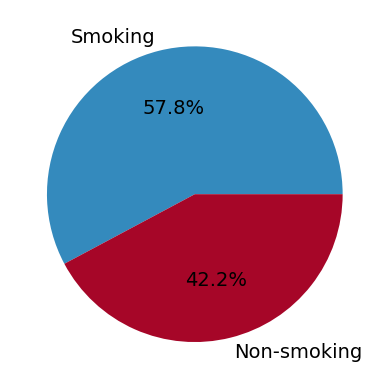

In [17]:
plt.pie(df_train['smoking'].value_counts(), labels=['Smoking', 'Non-smoking'], autopct='%1.1f%%', textprops={'fontsize': 14});

## Distribution of features

We can see below that some features have skewed distrubutions and others have been bucketed. Features such as hemoglobin and waist have clear differences in their smoking distributions. 

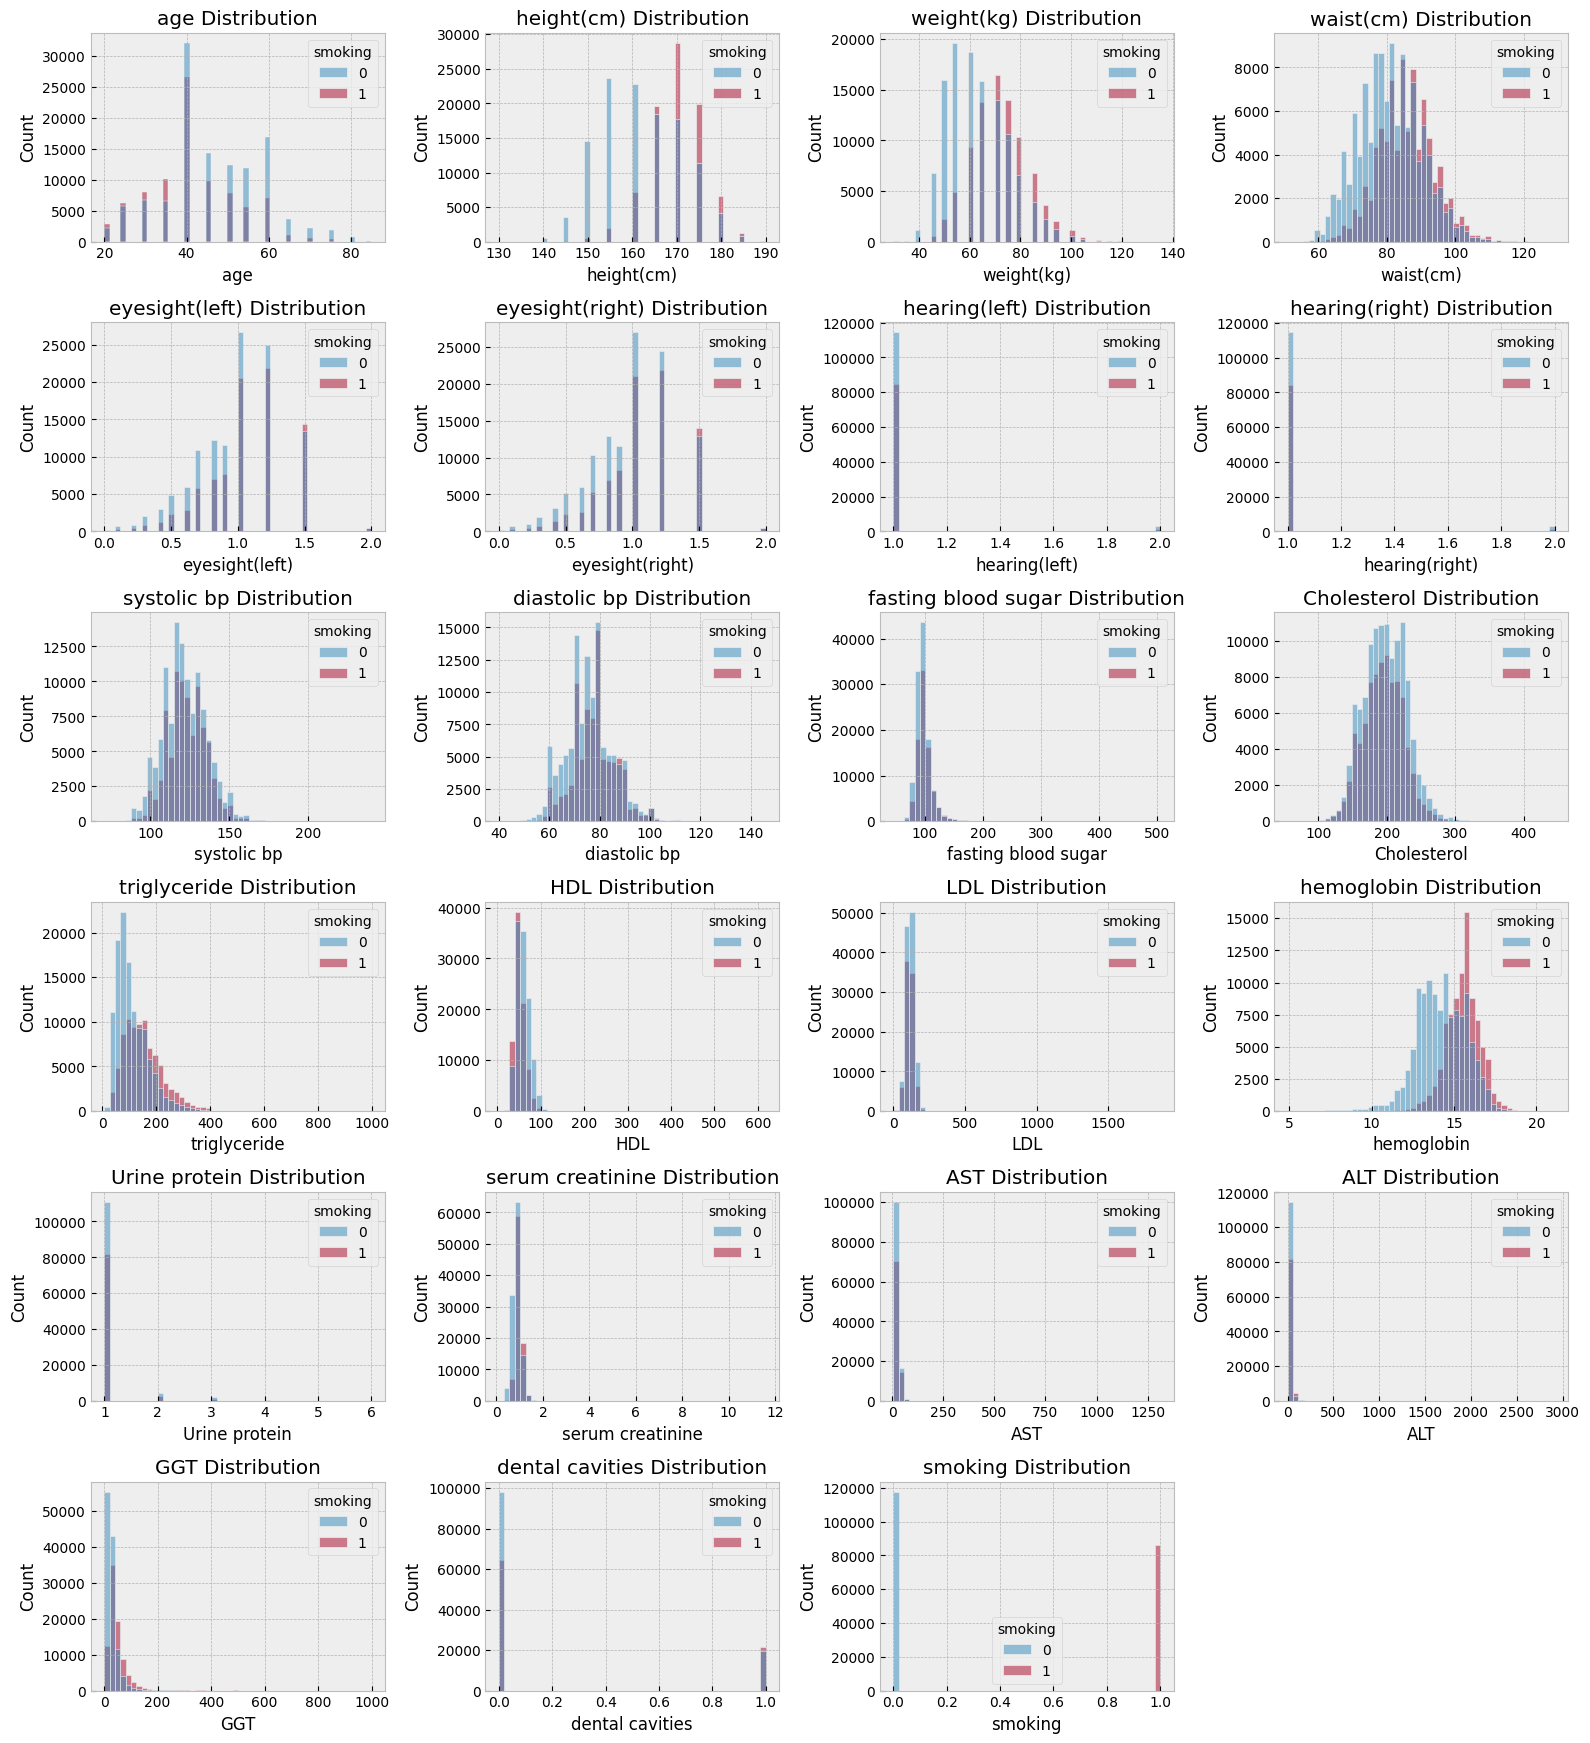

In [18]:
num_cols = len(df_train.columns)
plt.figure(figsize=(16, num_cols*1.5))
for i, col in enumerate(df_train.columns):
    plt.subplot(num_cols//2 + num_cols%2, 4, i + 1)
    sns.histplot(x=col, hue='smoking', data=df_train, bins=50)
    plt.title(f'{col} Distribution')
    plt.tight_layout()
plt.show()

### Log transform

We create a function to apply a log transform to try to normalize the features with skewed distributions.

In [19]:
def apply_log_transform(df):
    features = list(df.columns)
    if 'smoking' in features:
        features.remove('smoking')
    for col in features:
        df[col] = df[col].apply(lambda x: np.log1p(x))
    return df

In [20]:
df_train = apply_log_transform(df_train)
df_test = apply_log_transform(df_test)

## Feature Importance

### Smoking Rate
**Smoking rate**: Difference between mean of the target variable and mean of categories for a feature. If this difference is greater than 0, it means that the category is less likely to be smoking, and if the difference is lower than 0, the group is more likely to be smoking. The larger differences are indicators that a variable is more important than others.

In [21]:
global_smoking = df_train.smoking.mean()
global_smoking

0.4219903046004082

In [22]:
df_train[df_train['dental cavities'] == 0].smoking.mean()

0.3959069321651727

In [23]:
categorical_cols = [
    'age',
    'height(cm)',
    'weight(kg)',
    'hearing(left)',
    'hearing(right)',
    'dental cavities'
]
for c in categorical_cols:
    print(c)
    df_group = df_train.groupby(c).smoking.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_smoking
    df_group['risk'] = df_group['mean'] / global_smoking
    display(df_group)
    print()
    print()

age


,mean,count,diff,risk
age,,,,
3.044522,0.554276,5122,0.132285,1.313480
3.258097,0.516985,11952,0.094994,1.225110
3.433987,0.541914,14685,0.119923,1.284185
3.583519,0.603320,16686,0.181330,1.429701
3.713572,0.452238,58770,0.030247,1.071678
3.828641,0.403870,24134,-0.018120,0.957060
3.912023,0.000000,1,-0.421990,0.000000
3.931826,0.388809,20195,-0.033181,0.921370
4.025352,0.321184,17504,-0.100807,0.761116




height(cm)


,mean,count,diff,risk
height(cm),,,,
4.875197,0.000000,1,-0.421990,0.000000
4.912655,0.153846,13,-0.268144,0.364573
4.941642,0.000000,1,-0.421990,0.000000
4.948760,0.017301,578,-0.404689,0.040999
4.983607,0.030678,3716,-0.391312,0.072699
5.017280,0.034216,15139,-0.387774,0.081083
5.049856,0.077142,25680,-0.344849,0.182805
5.081404,0.238947,29923,-0.183044,0.566237
5.111988,0.516309,38078,0.094318,1.223508




weight(kg)


,mean,count,diff,risk
weight(kg),,,,
3.433987,0.105263,19,-0.316727,0.249444
3.583519,0.064103,78,-0.357888,0.151905
3.713572,0.068146,1262,-0.353845,0.161487
3.828641,0.070060,7308,-0.351930,0.166023
3.931826,0.122994,18196,-0.298996,0.291462
4.025352,0.200667,24583,-0.221323,0.475525
4.110874,0.333594,28145,-0.088396,0.790525
4.189655,0.464336,29666,0.042346,1.100348
4.262680,0.540247,30375,0.118257,1.280235




hearing(left)


,mean,count,diff,risk
hearing(left),,,,
0.693147,0.424734,198849,0.002744,1.006503
1.098612,0.311958,4959,-0.110032,0.739254




hearing(right)


,mean,count,diff,risk
hearing(right),,,,
0.693147,0.424547,198918,0.002556,1.006058
1.098612,0.317996,4890,-0.103994,0.753562




dental cavities


,mean,count,diff,risk
dental cavities,,,,
0.000000,0.395907,162763,-0.026083,0.938190
0.693147,0.525423,41045,0.103433,1.245108


### Correlation Matrix

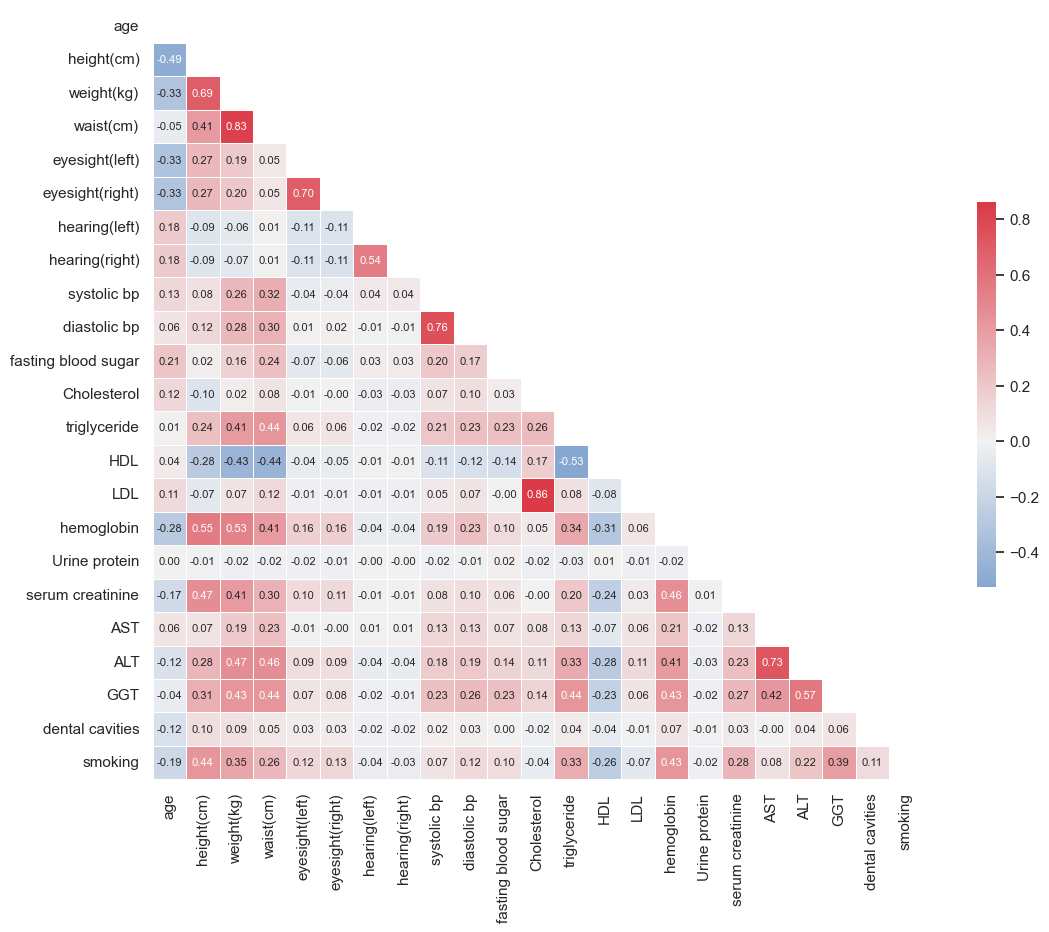

In [24]:
sns.set_theme(style="white")

corr_mat = df_train.corr()
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
fig, ax = plt.subplots(figsize=(14, 10))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr_mat, mask=mask, cmap=cmap, center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            fmt='.2f', annot=True, annot_kws={'size': 8});

# Model Selection

We will train and tune the following models to see which offers the best performance: 

* Logistic Regression
* Random Forest
* XGBoost

We will use Stratified K-Fold validation with 5 folds to evaluate the performance of our models.

In [25]:
X_train = df_train.drop(columns=['smoking'])
y_train = df_train['smoking']

In [26]:
def fit_model_with_skf(X, y, model, n_splits=5, random_state=SEED, shuffle=True):
    """
    Fit a sklearn model using stratified k-fold validation.

    Parameters:
    * X: Training data
    * y: Training labels
    * model: sklearn model to be fitted
    * n_splits: number of folds for cross validation (default 5)
    * random_state: random state to reproduce results (default SEED set at top of notebook)
    # shuffle: whether or not to shuffle the data in the folds (default True)
    
    Returns:
    A list of the average score and standard deviation of the fold
    """
    skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    scores = []
    fold = 1
    for train_idx, val_idx in skf.split(X, y):
        print(f'    Training fold {fold}...', end='\r')
        fold += 1
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print(' '*30, end='\r')
    return [np.mean(scores), np.std(scores)]

## Logistic Regression

The best score we get is 0.8364 with C=1

In [27]:
C_list = [0.001, 0.01, 0.1, 1, 10]
overall_scores = []
for C in C_list:
    print(f'Trying C={C}')
    model = LogisticRegression(solver='lbfgs', C=C, random_state=SEED, max_iter=1000)
    fold_score = fit_model_with_skf(X_train, y_train, model)
    fold_score.append(C)
    overall_scores.append(fold_score)

Trying C=0.001
Trying C=0.01                 
Trying C=0.1                  
Trying C=1                    
Trying C=10                   


In [28]:
for mean, std, C in overall_scores:
    print(f'C={C: <5} mean: {mean:.4f}, std: +- {std:.4f}')

C=0.001 mean: 0.8102, std: +- 0.0017
C=0.01  mean: 0.8289, std: +- 0.0015
C=0.1   mean: 0.8360, std: +- 0.0014
C=1     mean: 0.8364, std: +- 0.0014
C=10    mean: 0.8364, std: +- 0.0014


In [29]:
log_reg_final = LogisticRegression(solver='lbfgs', C=1, random_state=SEED, max_iter=1000)

## Random Forest

We see below that the best score is 0.8563 with max_depth=20, n_estimators=200, and min_samples=5

In [30]:
depths = [18, 20, 22]

overall_scores = []
for d in depths:
    print(f'Trying d={d}')
    for n in range(100, 201, 10):
        model = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=SEED,
                                        n_jobs=-1, min_samples_leaf=1)
        fold_score = fit_model_with_skf(X_train, y_train, model)
        overall_scores.append((d, n, *fold_score))

Trying d=18
Trying d=20                   
Trying d=22                   


In [31]:
columns = ['max_depth', 'n_estimators', 'mean_auc', 'std_auc']
df_scores = pd.DataFrame(overall_scores, columns=columns)

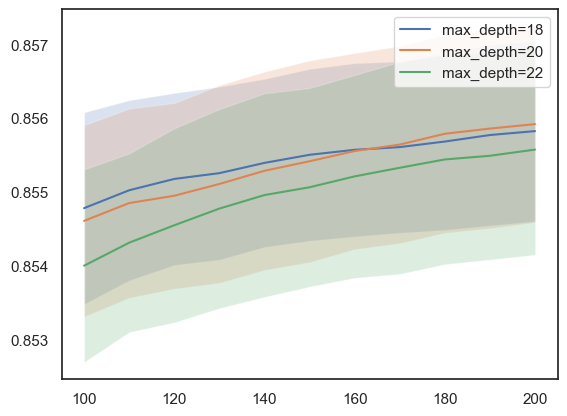

In [32]:
for d in depths:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.mean_auc,
            label='max_depth=%d' % d)
    plt.fill_between(df_subset.n_estimators, df_subset.mean_auc - df_subset.std_auc, 
                    df_subset.mean_auc + df_subset.std_auc, alpha=0.2)

plt.legend()

* max_depth: 15, n_estimators: 200, mean score: 0.855160
* max_depth: 20, n_estimators: 200, mean score: 0.855888

In [33]:
best_max_depth = 20

In [34]:
min_samples = [4, 5, 6]

overall_scores = []
for s in min_samples:
    print(f'Trying s={s}')
    for n in range(100, 201, 10):
        model = RandomForestClassifier(n_estimators=n, max_depth=best_max_depth, random_state=SEED,
                                        n_jobs=-1, min_samples_leaf=s)
        fold_score = fit_model_with_skf(X_train, y_train, model)
        overall_scores.append((s, n, *fold_score))

Trying s=4


Trying s=5                    
Trying s=6                    


In [35]:
columns = ['min_samples_leaf', 'n_estimators', 'auc', 'auc_std']
df_scores = pd.DataFrame(overall_scores, columns=columns)

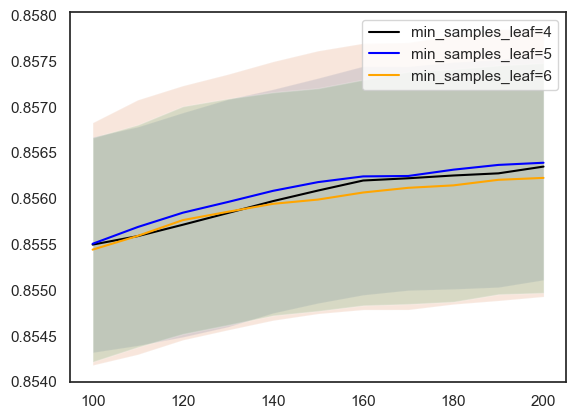

In [36]:
colors = ['black', 'blue', 'orange', 'red', 'grey']

for s, col in zip(min_samples, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)
    plt.fill_between(df_subset.n_estimators, df_subset.auc - df_subset.auc_std, 
                df_subset.auc + df_subset.auc_std, alpha=0.2)

plt.legend()

In [37]:
best_min_samples = 5

In [38]:
rf_final = RandomForestClassifier(n_estimators=200, max_depth=best_max_depth, random_state=SEED,
                                n_jobs=-1, min_samples_leaf=best_min_samples)

## XGBoost

In [39]:
xgb_default_params = {
    'learning_rate': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    'n_estimators': 100,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': SEED,
    'verbosity': 1,
    'n_jobs': -1
}


In [40]:
params = xgb_default_params.copy()
depths = [8, 9, 10]

overall_scores = []
for d in depths:
    print(f'Trying d={d}')
    params['max_depth'] = d
    for n in range(100, 201, 10):
        params['n_estimators'] = n
        model = XGBClassifier(**params)
        fold_score = fit_model_with_skf(X_train, y_train, model)
        overall_scores.append((d, n, *fold_score))

Trying d=8


Trying d=9                    
Trying d=10                   


In [41]:
columns = ['max_depth', 'n_estimators', 'mean_auc', 'std_auc']
df_scores = pd.DataFrame(overall_scores, columns=columns)

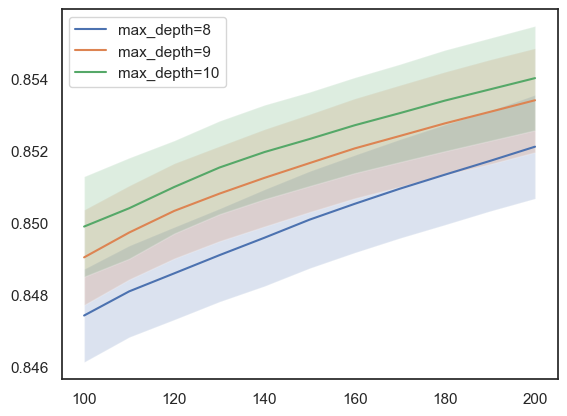

In [42]:
for d in depths:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.mean_auc,
            label='max_depth=%d' % d)
    plt.fill_between(df_subset.n_estimators, df_subset.mean_auc - df_subset.std_auc, 
                    df_subset.mean_auc + df_subset.std_auc, alpha=0.2)

plt.legend()

In [43]:
best_max_depth = 10
xgb_default_params['max_depth'] = best_max_depth

In [44]:
params = xgb_default_params.copy()
learning_rates = [0.01, 0.05, 0.1]

overall_scores = []
for lr in learning_rates:
    print(f'Trying learning_rate={lr}')
    params['learning_rate'] = lr
    for n in range(100, 201, 10):
        params['n_estimators'] = n
        model = XGBClassifier(**params)
        fold_score = fit_model_with_skf(X_train, y_train, model)
        overall_scores.append((lr, n, *fold_score))

Trying learning_rate=0.01
Trying learning_rate=0.05     
Trying learning_rate=0.1      


In [45]:
columns = ['learning_rate', 'n_estimators', 'mean_auc', 'std_auc']
df_scores = pd.DataFrame(overall_scores, columns=columns)

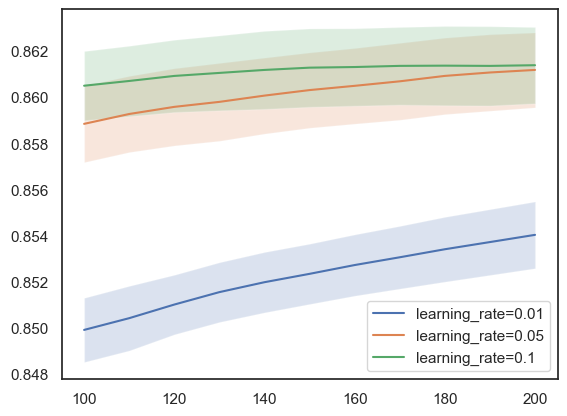

In [46]:
for r in learning_rates:
    df_subset = df_scores[df_scores.learning_rate == r]
    
    plt.plot(df_subset.n_estimators, df_subset.mean_auc,
            label=f'learning_rate={r}')
    plt.fill_between(df_subset.n_estimators, df_subset.mean_auc - df_subset.std_auc, 
                    df_subset.mean_auc + df_subset.std_auc, alpha=0.2)

plt.legend()

In [47]:
xgb_default_params['learning_rate'] = 0.1

In [48]:
params = xgb_default_params.copy()
min_child_weights = [25, 30, 35]

overall_scores = []
for w in min_child_weights:
    print(f'Trying min_child_weight={w}')
    params['min_child_weight'] = w
    for n in range(100, 201, 10):
        params['n_estimators'] = n
        model = XGBClassifier(**params)
        fold_score = fit_model_with_skf(X_train, y_train, model)
        overall_scores.append((w, n, *fold_score))

Trying min_child_weight=25


Trying min_child_weight=30    
Trying min_child_weight=35    


In [49]:
columns = ['min_child_weights', 'n_estimators', 'mean_auc', 'std_auc']
df_scores = pd.DataFrame(overall_scores, columns=columns)

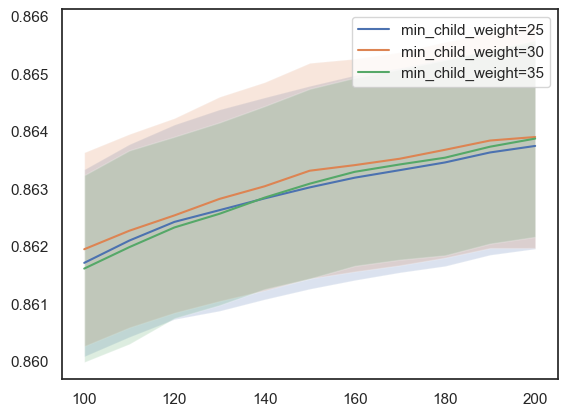

In [50]:
for w in min_child_weights:
    df_subset = df_scores[df_scores.min_child_weights == w]
    
    plt.plot(df_subset.n_estimators, df_subset.mean_auc,
            label=f'min_child_weight={w}')
    plt.fill_between(df_subset.n_estimators, df_subset.mean_auc - df_subset.std_auc, 
                    df_subset.mean_auc + df_subset.std_auc, alpha=0.2)

plt.legend()

In [51]:
xgb_final_params = {
    'learning_rate': 0.1, 
    'max_depth': 10,
    'min_child_weight': 25,
    'n_estimators': 200,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': SEED,
    'verbosity': 1,
    'n_jobs': -1
}

In [52]:
xgb_final = XGBClassifier(**xgb_final_params)

## Selecting the final model

We see below that our XGBoost classifier has the best score. 

In [53]:
classifiers = [log_reg_final, rf_final, xgb_final]

model_scores = []
for model in classifiers:
    model_name = model.__class__.__name__
    print(f'Fitting {model_name}')
    score = fit_model_with_skf(X_train, y_train, model)
    model_scores.append((model_name, *score))

Fitting LogisticRegression


Fitting RandomForestClassifier
Fitting XGBClassifier         


In [54]:
for name, mean, std in model_scores:
    print(f'{name: <22} mean: {mean:.4f}, std: +- {std:.4f}')

LogisticRegression     mean: 0.8364, std: +- 0.0014
RandomForestClassifier mean: 0.8564, std: +- 0.0015
XGBClassifier          mean: 0.8637, std: +- 0.0018


* LogisticRegression     mean: 0.8364, std: +- 0.0014
* RandomForestClassifier mean: 0.8564, std: +- 0.0015
* XGBClassifier          mean: 0.8637, std: +- 0.0018

In [55]:
xgb_final.fit(X_train, y_train)
final_pred = xgb_final.predict_proba(df_test)[:, 1]